## 5.3.1 A simple example with unknown parameters

알지 못하는 변소를 포함하는 모델에 대한 입자 필터 적용의 단순한 예시로써 5.1.1장의 예제로 돌아가 보겠습니다. 여기서는 시스템과 관측 변수를 알지 못한다고 가정하겠습니다. 2개의 알지 못하는 양의 변수가 있기 때문에 변수의 사후 분포에 대한 혼합 추정으로 임의의 시간 $t$에서 감마 커널의 곱을 사용할 것입니다. 이전 장의 표기에서 $\psi_1=V$, $\psi_2=W$를 사용했었고, $f_j(\psi_j;\gamma_j)$는 $j=1,2$에 대한 감마 밀도이며, $\gamma_j=(\alpha_j,\beta_j)$는 감마 분포의 표준 벡터 변수(부록 A 참조)입니다. 5.1.1장에서 사용한 동일한 시뮬레이션 데이터를 사용하겠습니다. $V$와 $W$에 대하여 독립적인 균일 분포 $U(0,10)$를 사전 분포로 선택하겠습니다. 데이터에 대한 그래프를 보면, 변수의 실제 값을 포함하기 위한 구간으로써 분산의 상한치가 10이면 충분한 것을 알 수 있습니다. 이 경계 내에서는 균일 사전분포는 알지 못하는 분산에 대한 어떠한 중요한 정보도 제공하지 않습니다. 더 넓게 퍼진 사전분포를 선택하지 않은 이유는 입자 필터 알고리즘은 초기에 사전 분포에서 입자들을 생성하고, 만약 사전 분포가 가능도가 높은 영역에 낮은 확률을 부여하게 되면 한두 스텝 이후에 대부분의 입자들이 버려질 것이기 때문입니다. 특정 숫자를 기반으로 한 사전분포 선택에 대해 고려하지 않았음을 주목하기 바랍니다. 이와 대조적으로, 이 경우, 유한한 구간에 대한 균일 사전분포는 무한한 분산을 갖는 사전 분포보다 분산에 대한 기존 정보를 더 잘 나타내게 됩니다. 무엇보다도, 데이터의 그래프를 그려보면 그 누구도 $V$가 100 또는 1000 처럼 큰 경우에 대해 고려하지 않을 것입니다.

In [1]:
require("dlm")

Loading required package: dlm
Warning message:
"package 'dlm' was built under R version 3.6.3"

In [2]:
### 데이터 생성
# 모델
mod <- dlmModPoly(1, dV = 2, dW = 1, m0 = 10, C0 = 9)
#names(mod)
# 데이터 수
n <- 100
set.seed(23)
# Forecast를 통한 데이터 생성
simData <- dlmForecast(mod = mod, nAhead = n, sampleNew = 1)
#names(simData)

In [15]:
m0 = mod$m0; C0 = mod$C0;
V = mod$V;   W = mod$W;

In [4]:
a = simData$a; R = simData$R; f = simData$f; Q = simData$Q;
newStates = simData$newStates; newObs = simData$newObs;
y = simData$newObs[[1]];

In [5]:
### 알지 못하는 변수(측정오차분산, 상태오차분산)를 포함하는 
### 모델에 대한 입자필터: Liu and West 방법
# 입자 개수
N <- 10000
# 229 page 참조
a <- 0.975
set.seed(4521)
# 입자필터 결과물
# Theta = 상태 / V = 측정오차분산 / W = 상태오차분산
pfOutTheta <- matrix(NA_real_,n+1,N)
pfOutV <- matrix(NA_real_,n+1,N)
pfOutW <- matrix(NA_real_,n+1,N)
# 가중치
wt <- matrix(NA_real_,n+1,N)
## 사전분포에서 초기값 샘플
# Theta의 사전 분포는 N(m0=10,C0=9)
# V, W의 사전 분포는 U(0,10)
pfOutTheta[1,] <- rnorm(N, mean=m0,sd=sqrt(C0))
pfOutV[1,] <- runif(N,0,10)
pfOutW[1,] <- runif(N,0,10)
## 초기 가중치
wt[1,] <- rep(1/N,N)

In [7]:
## 입자필터 시작
for (it in 2 : (n+1)){
    ## 입자의 평균 및 분산 계산
    # 가중평균 사용
    meanV <- weighted.mean(pfOutV[it-1,],wt[it-1,])
    meanW <- weighted.mean(pfOutW[it-1,],wt[it-1,])
    varV <- weighted.mean((pfOutV[it-1,]-meanV)^2,wt[it-1,])
    varW <- weighted.mean((pfOutW[it-1,]-meanW)^2,wt[it-1,])
    
    ## 감마 커널의 변수들 계산
    # V 관련 변수들
    muV <- a * pfOutV[it-1,] + (1-a) * meanV
    sigma2V <- (1-a^2) * varV
    alphaV <- muV^2 / sigma2V
    betaV <- muV / sigma2V
    # W 관련 변수들
    muW <- a * pfOutW[it-1,] + (1-a) * meanW
    sigma2W <- (1-a^2) * varW
    alphaW <- muW^2 / sigma2W
    betaW <- muW / sigma2W
    
    ## 보조 지시 변수들을 샘플링
    probs <- wt[it-1,] * dnorm(y[it-1], sd = sqrt(muV), mean = pfOutTheta[it-1, ])
    auxInd <- sample(N, N, replace = TRUE, prob = probs)
    
    ## 분산 V와 W를 샘플
    pfOutV[it,] <- rgamma(N, shape = alphaV[auxInd], rate = betaV[auxInd])
    pfOutW[it,] <- rgamma(N, shape = alphaW[auxInd], rate = betaW[auxInd])
    
    ## 상태 Theta를 샘플
    pfOutTheta[it,] <- rnorm(N, mean = pfOutTheta[it-1, auxInd], sd = sqrt(pfOutW[it,]))
    
    ## 가중치 계산
    wt[it,] <- exp(dnorm(y[it-1], 
                         mean = pfOutTheta[it,], 
                         sd = sqrt(pfOutV[it,]), 
                         log = TRUE)
                  -dnorm(y[it-1],
                         mean = pfOutTheta[it-1,auxInd], 
                         sd = sqrt(muV[auxInd]), 
                         log = TRUE))
    
    ## 가중치 정규화
    wt[it,] <- wt[it,] / sum(wt[it,])    
}

In [17]:
trueV = rep(V,n); trueW = rep(W,n);

In [28]:
thetaHatPF <- sapply(1:n, function(i)
                     weighted.mean(pfOutTheta[i,], wt[i,]))

In [31]:
VHatPF <- sapply(1:n, function(i)
                     weighted.mean(pfOutV[i,], wt[i,]))

In [30]:
length(thetaHatPF)

[1] 100

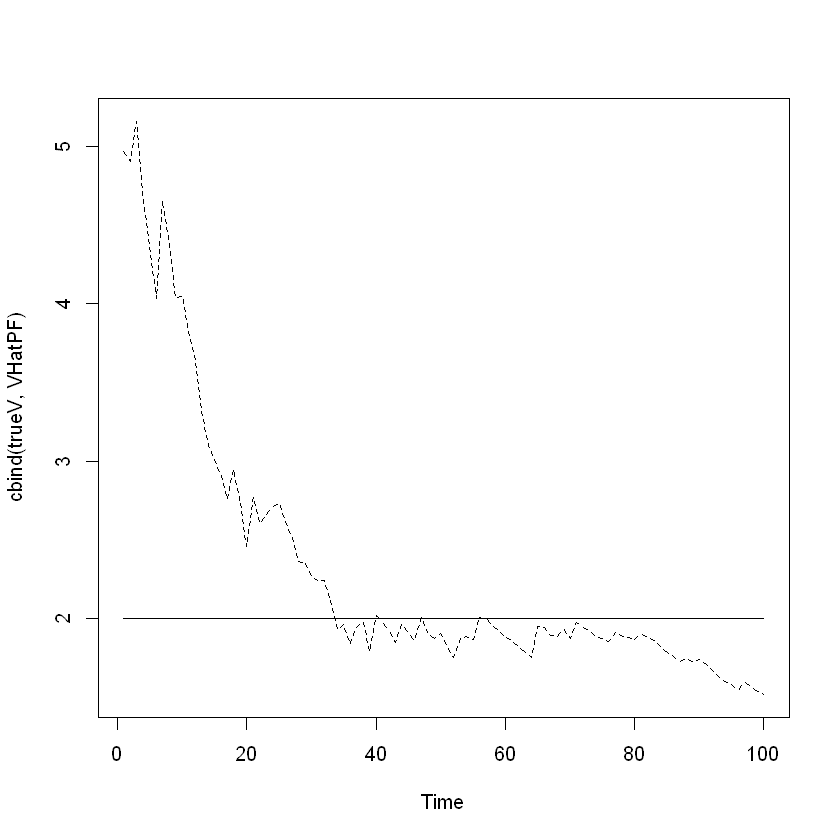

In [32]:
plot.ts(cbind(trueV,VHatPF),plot.type="single",lty=1:3);

In [22]:
length(trueV)

[1] 100

In [25]:
length(pfOutV[-1,10000])

[1] 100